# Saving `dysh` data to external files
This notebook gives examples of how to write out selected data from [`GBTFitsLoad`](https://dysh.readthedocs.io/en/latest/modules/dysh.fits.html#module-dysh.fits.gbtfitsload) and how to save 
[`Spectrum`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.spectrum), 
[`Scan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.scan), and 
[`ScanBlock`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock) to different formats.

In [ ]:
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.spectrum import Spectrum
from dysh.util.download import from_url
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

## Let's start with `GBTFITSLoad`
First read  in some data

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/onoff-L/data/TGBT21A_501_11.raw.vegas.fits"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

TGBT21A_501_11.raw.vegas.fits already downloaded


In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152,NGC2415,3784.0,OnOff,1,1.617185,1.420406,5,2,151,1,286.218008,41.62843
1,153,NGC2415,3784.0,OnOff,2,1.617185,1.420406,5,2,151,1,286.886521,41.118134


### Calibrate a position switched scan.  This returns a `ScanBlock` containing one [`PSScan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.PSScan) with 151 ONs and 151 OFFs.

In [4]:
psscan = sdfits.getps(scan=152, ifnum=0, plnum=0)

In [5]:
print(f"Number of integrations = {psscan[0].nrows}")

Number of integrations = 302


## Get the time average of the calibrated data
This method returns a `Spectrum`.

In [6]:
ta = psscan.timeaverage()

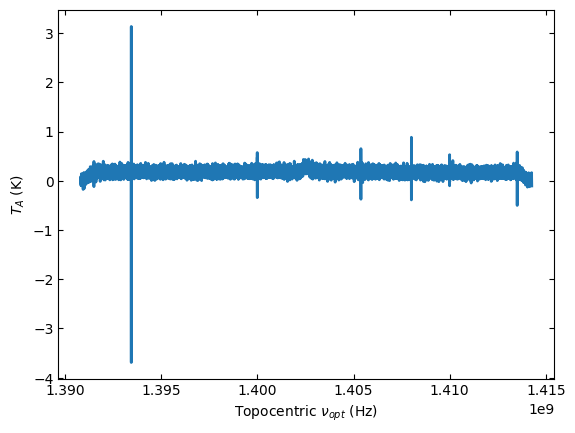

In [7]:
ta.plot()

---

## Reading and Writing Individual Spectra

##  Inputs and Outputs
`dysh` supports output to text files in a variety of [formats familiar to users of astropy](https://docs.astropy.org/en/stable/io/ascii/index.html#id1):
* basic
* commented_header
* ECSV
* fixed_width
* IPAC
* MRT
* votable

In [8]:
fmt = [ 
    "basic",
    "commented_header",
    "ecsv",
    "fixed_width",
    "ipac",
    "mrt",
    "votable",
]
output_dir = Path.cwd() / "output"
for f in fmt:
    file = output_dir / f"testwrite.{f}"
    ta.write(file, format=f, overwrite=True)


### We can also write a spectrum to FITS format

In [9]:
ta.write(output_dir / "testwrite.fits", format="fits", overwrite=True)

### We can read spectra in FITS and a few formats
[As noted in astropy, ECSV ](https://docs.astropy.org/en/stable/io/ascii/ecsv.html#ecsv-format) is the only ASCII format that can make a lossless output-input roundtrip and thus reproduce an original spectrum.

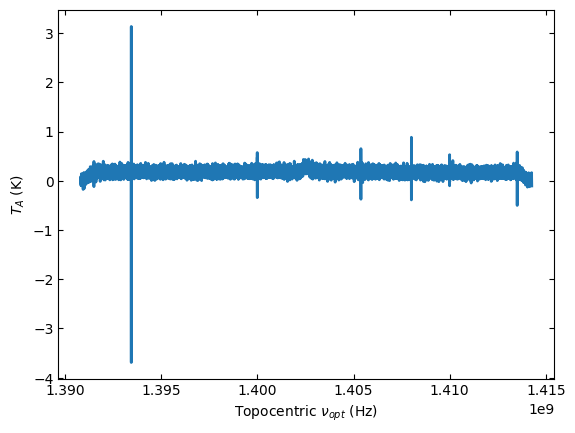

In [10]:
s1 = Spectrum.read(output_dir / "testwrite.fits", format="fits")
s1.plot()

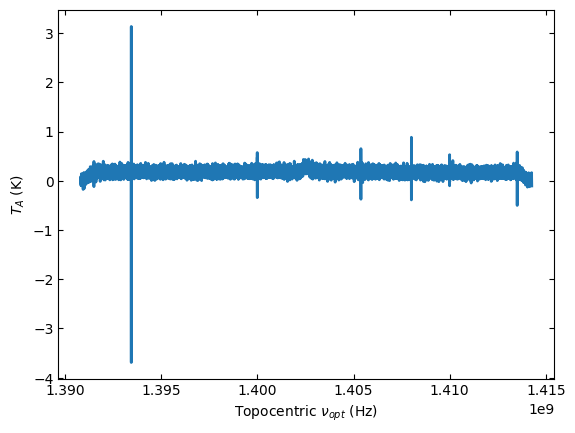

In [11]:
s2 = Spectrum.read(output_dir / "testwrite.ecsv", format="ecsv")
s2.plot()

### GBTIDL ASCII format
`dysh` can read text files created by GBTIDL's `write_ascii` function. However, those files do not provide sufficient metadata to fully recreate the spectrum.  (For instance, they do not have complete sky coordinate information).  

In [12]:
s3 = Spectrum.read("data/onoff-L_gettp_156_intnum_0_HEL.ascii", format='gbtidl')

In [13]:
print(s3, "\n", s3.meta)

Spectrum1D (length=32768)
flux:             [ 3.6087e+06 ct, ..., 3.4748e+06 ct ],  mean=nan ct
spectral axis:    [ 1.4201 GHz, ..., 1.3967 GHz ],  mean=1.4084 GHz 
 {'SCAN': 156, 'OBJECT': 'NGC2782', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 119.42083333333332, 'VELDEF': 'None-HEL', 'POL': 'YY'}


### `dysh` can even read compressed ASCII files
Note these data have velocity on the spectral axis

In [14]:
s4 = Spectrum.read("data/onoff-L_getps_152_RADI-HEL.ascii.gz", format='gbtidl')

In [15]:
print(s4, "\n", s4.meta)

Spectrum1D (length=32768)
flux:             [ -0.10425 K, ..., 0.061399 K ],  mean=nan K
spectral axis:    [ 1281.2 km / s, ..., 6228.0 km / s ],  mean=3754.6 km / s 
 {'SCAN': 152, 'OBJECT': 'NGC2415', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 114.65624999999999, 'VELDEF': 'RADI-HEL', 'POL': 'YY'}


#### Plot it with simple matplotlib commands

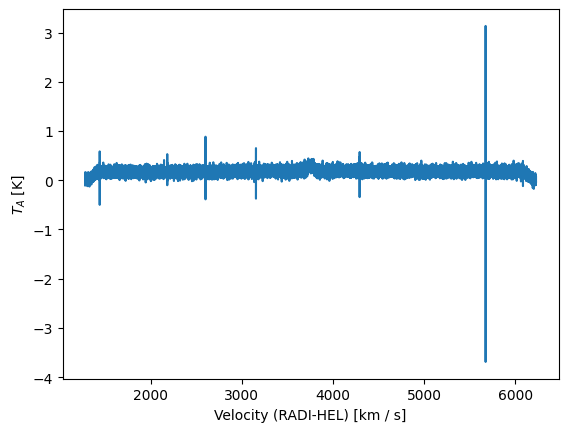

In [16]:
plt.figure()
plt.xlabel(f"Velocity ({s4.meta['VELDEF']}) [{s4.spectral_axis.unit}]")
plt.ylabel(f"$T_A$ [{s4.flux.unit}]")
plt.plot(s4.spectral_axis, s4.flux)

---

## Writing Calibrated Data to SDFITS
You can write the calibrated data from a ScanBlock in SDFITS format.  If there are multiple Scans in the ScanBlock, they will all be written to the same binary table (useful for gbtgridder)

In [17]:
psscan.write(output_dir / "scanblock.fits", overwrite=True)

---

## Writing out selected data from `GBTFITSLoad`
The `write()` method of `GBTFITSLoad` supports down-selection of data. Data can be selected on any SDFITS column.

In [18]:
sdfits.write(output_dir / "mydata.fits", plnum=1, ifnum=[0,2], intnum=np.arange(100), overwrite=True)

### These data, can of course, be read back in

In [19]:
# Try-Except added to handle a bug on MacOS
try:
    sdfits2 = GBTFITSLoad(output_dir / "mydata.fits")
except:
    sdfits2 = GBTFITSLoad(output_dir / "mydata0.fits")
sdfits2.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152,NGC2415,3784.0,OnOff,1,1.542904,1.420406,2,1,100,1,286.12712,41.788288
1,153,NGC2415,3784.0,OnOff,2,1.542904,1.420406,2,1,100,1,286.796519,41.277416


### Writing SDFITS to multiple files 
If the data came from multiple files, for instance VEGAS banks, then by default they are written to multiple files, so
`sdfits.write('mydata.fits') `
would write to mydata0.fits, mydata1.fits, ... mydataN.fits.
A future enhancement will preserve the A,B,C alphabetic extensions of the input data.